## IMPORT LIBRARIES


#LSTM Practice Implementation

this model does the following:


*   Takes in historical OHLC data for a given stock (APPL in this case)  from 2010-01-01 to 2024-01-01
*   Preprocesses the stock prices by normalizing them and generating a simple moving average
*   Creates a 30 day sequence of data as input to predict the next day
*   Trains on the historical data from polygon.io
*   Predicts and generates buy/sell signals and expected returns based on a computed threshold







In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import time

API_KEY='q6YjvzTWAp_OkhFvfxwfgrtIVOpddl_V'
BASE_URL='https:/api.polygon.io'


##IMPORT HISTORICAL DATA

In [2]:
def get_historical_stock_data(ticker, start_date, end_date):
    url = f" https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/2010-01-01/2024-01-01?adjusted=true&sort=asc&limit=5000&apiKey=q6YjvzTWAp_OkhFvfxwfgrtIVOpddl_V"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for non-200 status codes

        # Check if response is valid JSON
        data = response.json()

        # Check if 'results' is in the response (indicates data is present)
        if 'results' in data and data['results']:
            df = pd.DataFrame(data['results'])
            df['t'] = pd.to_datetime(df['t'], unit='ms')  # Convert timestamp to date
            df.set_index('t', inplace=True)
            return df[['o', 'h', 'l', 'c', 'v']]  # Keep OHLC and volume columns
        else:
            print(f"No data available for {ticker} in the specified date range.")
            return pd.DataFrame()  # Return an empty DataFrame if no data

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()
    except ValueError as e:
        print(f"JSON decode error for {ticker}: {e}")
        return pd.DataFrame()

tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT']

def get_data_for_multiple_tickers(tickers, start_date, end_date):
  all_data = {}
  for ticker in tickers:
    data = get_historical_stock_data(ticker, start_date, end_date)
    print(f"fetched data for {ticker}")
    time.sleep(1)
    if data is not None:
      all_data[ticker] = data
  return all_data



#example test of getting stock data
start_date = '2010-01-01'
end_date = '2024-01-01'
data = get_data_for_multiple_tickers(tickers, start_date, end_date)

combined_data = pd.concat(data.values(), keys=data.keys(), names=['Ticker', 'Date'])
print(combined_data.head())

fetched data for AAPL
fetched data for AMZN
fetched data for GOOGL
fetched data for MSFT
                                  o       h         l       c           v
Ticker Date                                                              
AAPL   2022-11-15 05:00:00  152.215  153.59  148.5613  150.04  89868332.0
       2022-11-16 05:00:00  149.130  149.87  147.2900  148.79  64218266.0
       2022-11-17 05:00:00  146.430  151.48  146.1500  150.72  80389400.0
       2022-11-18 05:00:00  152.305  152.70  149.9700  151.29  74829573.0
       2022-11-21 05:00:00  150.160  150.37  147.7150  148.01  58724070.0


##PREPROCESS DATA
###normalize stock prices and generate a simple moving average

In [4]:
from sklearn.preprocessing import MinMaxScaler
# Define function to create sequences
def create_sequences(df, window_size=30):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)  # Scale DataFrame and keep it as np.array
    X, y = [], []

    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size, :-1])  # Include all columns except the last
        y.append(scaled_data[i + window_size, -1])  # Target is the last column (returns)

    return np.array(X), np.array(y)

# Initialize lists to store sequences for multiple stocks
X_list, y_list = [], []

# Iterate through each ticker to calculate indicators and sequences
for ticker, df in data.items():
    # Calculate moving averages and returns
    df['SMA_10'] = df['c'].rolling(window=10).mean()
    df['SMA_50'] = df['c'].rolling(window=50).mean()
    df['Returns'] = df['c'].pct_change()
    df.dropna(inplace=True)  # Drop NaN values from rolling calculations

    # Create sequences from the scaled DataFrame
    X, y = create_sequences(df, window_size=30)
    X_list.append(X)
    y_list.append(y)

# Concatenate all sequences for the multi-stock model
X_multi = np.concatenate(X_list, axis=0)
y_multi = np.concatenate(y_list, axis=0)

# Adjust y_multi to have the correct shape
num_stocks = len(tickers)  # Number of assets
y_multi = np.repeat(y_multi, num_stocks).reshape(-1, num_stocks)

print(f"X_multi shape: {X_multi.shape}, y_multi shape: {y_multi.shape}")
# format --> X(total_samples, window_size, num_features); Y(total_samples, num_stocks)

X_multi shape: (812, 30, 7), y_multi shape: (812, 4)


###make sequences of input to predict the next day

##BUILD LSTM MODEL

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

num_stocks = len(tickers) # number of assets in input

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(num_stocks, activation='sigmoid')  # Sigmoid for probability output
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\hamme\OneDrive\Documents\GitHub\CS-491-Algorithmic-Trading-Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,004 (125.02 KB)

 Trainable params: 32,004 (125.02 KB)

 Non-trainable params: 0 (0.00 B)

####TRAINING THE MODEL

In [6]:
history = model.fit(X_multi, y_multi, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0172 - val_loss: 0.0459
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0171 - val_loss: 0.0504
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0178 - val_loss: 0.0435
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0155 - val_loss: 0.0458
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0157 - val_loss: 0.0424


####MAKE PREDICTIONS AND SIGNAL BUY OR SELL

In [10]:
def generate_multi_stock_signals(data, model, threshold=0.5):
    predictions = model.predict(data)
    signals = [
        'Buy' if pred > threshold else 'Sell'
        for pred in predictions[0]
    ]
    return predictions[0], signals

# Predict for the latest data
latest_data = X_multi[-1].reshape(1, X_multi.shape[1], X_multi.shape[2])
predicted_returns, signals = generate_multi_stock_signals(latest_data, model)

for i, ticker in enumerate(tickers):
    print(f"{ticker}: Predicted Return: {predicted_returns[i]:.2%}, Signal: {signals[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
AAPL: Predicted Return: 52.12%, Signal: Buy
AMZN: Predicted Return: 51.44%, Signal: Buy
GOOGL: Predicted Return: 51.03%, Signal: Buy
MSFT: Predicted Return: 51.80%, Signal: Buy


In [11]:
model.save('my_checkpoint.keras')



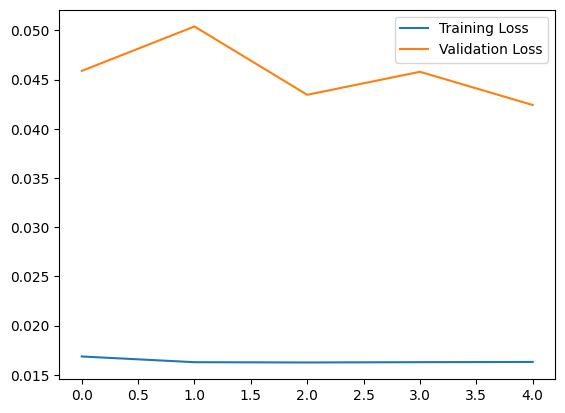

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()